### Cell 1 — Import Libraries & Setup

This cell loads all the required Python libraries used in this notebook:

- **pandas, numpy** → data processing  
- **matplotlib** → visual plots  
- **sklearn** → regression models & outlier detection  
- **IsolationForest** → used for anomaly detection  
- **Linear, Quadratic, Cubic models** → polynomial regression

It also creates a `/data` folder where the CSV file must be placed.

After running, the notebook prints a message telling the user where to put the CSV file.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import IsolationForest

os.makedirs("data", exist_ok=True)
print("Ready. Put your CSV inside: data/")


Ready. Put your CSV inside: data/


### Cell 2 — Load the CSV file from data/

This cell:

1. Defines the expected CSV location  
2. Checks if the file exists — otherwise raises an error  
3. Loads the CSV using `pd.read_csv()`  
4. Skips the first 2 rows because exports from Google Ads usually contain extra header info  
5. Prints dataset shape and previews the first rows

This ensures the raw dataset is successfully loaded into memory.


In [57]:
file_path = "data/Campaign budget analysis data export.csv"

if not os.path.exists(file_path):
    raise FileNotFoundError(f"CSV not found at {file_path}. Place it in the data/ folder.")

df = pd.read_csv(file_path, skiprows=2)
print("CSV loaded. Shape:", df.shape)
df.head()

CSV loaded. Shape: (7370, 11)


,Campaign,Day,Campaign ID,Budget,Clicks,Impr.,Currency code,Cost,CTR,Avg. CPC,Conversions
0,SBR Pravanika | Search | 25 Nov 22,NaN,19031976471,2000.0,0,0,INR,0.00,0,0.00,0.0
1,Valmark Cityville | Search | 25 Nov 22,22-11-24,19038490303,5000.0,0,0,INR,0.00,0,0.00,0.0
2,SBR Pravanika | Search | 25 Nov 22,2022-11-25,19031976471,2000.0,3,34,INR,411.98,8.82%,137.33,0.0
3,Valmark Cityville | Search | 25 Nov 22,2022-11-25,19038490303,5000.0,5,48,INR,870.50,10.42%,174.10,0.0
4,SBR Pravanika | Search | 25 Nov 22,2022-11-26,19031976471,2000.0,11,62,INR,1147.28,17.74%,104.30,2.0


### Cell 3 — Select important columns & clean numeric values

This step prepares your dataset for modeling:

- Renames `"Impr."` → `"Impressions"`  
- Keeps only required columns:
  - Impressions  
  - Clicks  
  - Conversions  
  - Cost  
- Removes commas (“1,200” → 1200)
- Removes percent symbols (“4.5%” → 4.5)
- Converts all values to numeric  
- Drops rows with missing values  

This results in a clean, numeric-only dataset ready for analysis.


In [58]:
df = df.rename(columns={
    "Impr.": "Impressions"
})

required_cols = ["Impressions", "Clicks", "Conversions", "Cost"]
df = df[required_cols].copy()

for col in required_cols:
    df[col] = (
        df[col]
        .astype(str)       
        .str.replace(",", "", regex=False)
        .str.replace("%", "", regex=False)
    )
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna()
print("Cleaned dataset shape:", df.shape)
df.head()


Cleaned dataset shape: (7370, 4)


,Impressions,Clicks,Conversions,Cost
0,0,0,0.0,0.00
1,0,0,0.0,0.00
2,34,3,0.0,411.98
3,48,5,0.0,870.50
4,62,11,2.0,1147.28


### Cell 4 — Outlier Detection + Visualization

This cell contains 3 functions:

---

#### 1️⃣ `plot_outlier_dots()`
Plots:
- **Green dots** → data points kept  
- **Red dots** → data points removed  

This helps visualize how filtering affects the dataset.

---

#### 2️⃣ `remove_outliers()`
Uses **IsolationForest** to detect abnormal values using:
- Impressions  
- Cost  

It ensures:
- At least 50% of data is always kept (safety rule)

This prevents over-removing data.

---

#### 3️⃣ `show_outlier_report()`
Produces a full report:
- Before row count  
- After row count  
- Number & percentage removed  
- Preview of filtered data  
- Scatter plot of kept vs removed  

Finally returns the cleaned dataframe (`df_clean`).

This is the first major cleaning stage before modeling.



📊 OUTLIER REMOVAL — BEFORE vs AFTER REPORT

                    Stage  Row Count  Rows Removed  Percent Removed
0  Before Outlier Removal       7370             0             0.00
1   After Outlier Removal       7222           148             2.01

Preview AFTER outlier removal:



,Impressions,Clicks,Conversions,Cost
0,0,0,0.0,0.00
1,0,0,0.0,0.00
2,34,3,0.0,411.98
3,48,5,0.0,870.50
4,62,11,2.0,1147.28


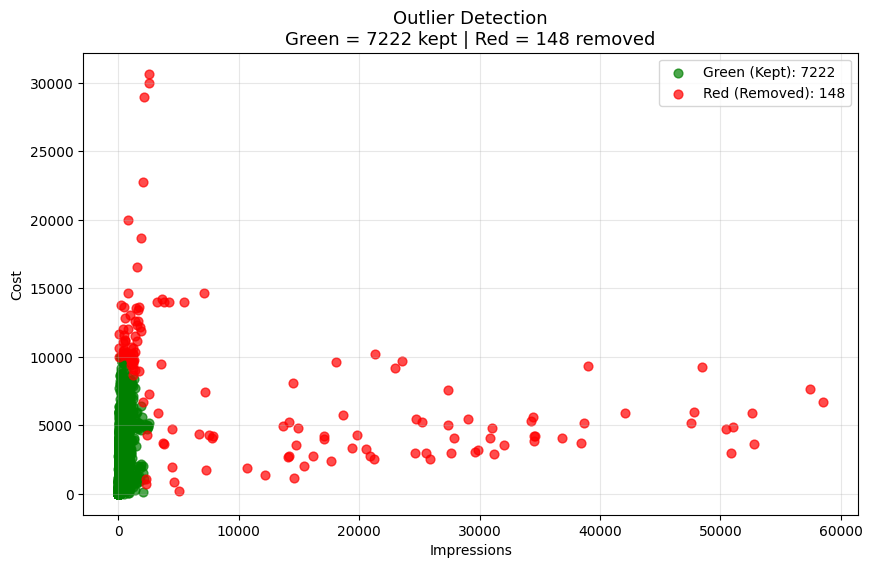

In [59]:
def plot_outlier_dots(before_df, after_df):
    plt.figure(figsize=(10,6))

    plt.scatter(
        after_df["Impressions"], after_df["Cost"],
        color="green", alpha=0.7, s=40,
        label=f"Green (Kept): {len(after_df)}"
    )

    removed_df = before_df[~before_df.index.isin(after_df.index)]
    plt.scatter(
        removed_df["Impressions"], removed_df["Cost"],
        color="red", alpha=0.7, s=40,
        label=f"Red (Removed): {len(removed_df)}"
    )

    plt.title(
        f"Outlier Detection\nGreen = {len(after_df)} kept | Red = {len(removed_df)} removed",
        fontsize=13
    )

    plt.xlabel("Impressions")
    plt.ylabel("Cost")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def remove_outliers(data, contamination=0.02):
    if len(data) < 10:
        return data
    
    iso = IsolationForest(contamination=contamination, random_state=42)
    mask = iso.fit_predict(data[["Impressions", "Cost"]]) == 1
    filtered = data[mask]

    # do not remove more than 50% of data
    if len(filtered) < len(data) * 0.5:
        return data
    
    return filtered


def show_outlier_report(df):
    print("\n📊 OUTLIER REMOVAL — BEFORE vs AFTER REPORT\n")

    before_rows = len(df)
    filtered = remove_outliers(df)
    after_rows = len(filtered)

    removed = before_rows - after_rows
    percent_removed = (removed / before_rows) * 100 if before_rows > 0 else 0

    # Summary table
    report_df = pd.DataFrame({
        "Stage": ["Before Outlier Removal", "After Outlier Removal"],
        "Row Count": [before_rows, after_rows],
        "Rows Removed": [0, removed],
        "Percent Removed": [0, round(percent_removed, 2)]
    })

    print(report_df)
    print("\nPreview AFTER outlier removal:\n")
    display(filtered.head())

    plot_outlier_dots(df, filtered)

    return filtered


df_clean = show_outlier_report(df)


### Cell 5 — Train Linear Regression (Degree 1)

This cell sets:

- **X** = Impressions  
- **Y** = Cost  

And trains a simple **Linear Regression** model:

`Cost = a × Impressions + b`

This captures a straight-line relationship between impressions and cost.


In [60]:
X = df_clean[["Impressions"]].values    
y = df_clean["Cost"].values

linear_model = LinearRegression()
linear_model.fit(X, y)

slope = linear_model.coef_[0]
intercept = linear_model.intercept_

print("Slope (m):", slope)
print("Intercept (b):", intercept)

print("Linear model trained.")


Slope (m): 4.0536554584061655
Intercept (b): 672.050825564326
Linear model trained.


### Cell 6 — Train Quadratic Model (Degree 2)

This model captures curved relationships:

`Cost = a × (Impressions²) + b × Impressions + c`

A polynomial pipeline is used:
- `PolynomialFeatures(2)`
- `LinearRegression()`

Quadratic models often fit marketing data better than linear.


In [61]:
quad_model = make_pipeline(
    PolynomialFeatures(2, include_bias=False),
    LinearRegression()
)
quad_model.fit(X, y)

print("Quadratic model trained.")


Quadratic model trained.


### Cell 7 — Train Cubic Model (Degree 3)

This trains a more flexible model:

`Cost = ax³ + bx² + cx + d`

Cubic models capture more complex non-linear patterns, but may overfit.

Together, cells 5–7 create 3 different mathematical models for comparison.


In [62]:
cubic_model = make_pipeline(
    PolynomialFeatures(3, include_bias=False),
    LinearRegression()
)
cubic_model.fit(X, y)

print("Cubic model trained.")


Cubic model trained.


### Cell 8 — Cost Prediction Using Impressions (Daily + Duration)

This cell calculates the **daily cost** and **total cost for a selected duration**  
based on a model trained only on **Impressions → Cost**.

### 🔢 User Inputs:
- **Impressions per day** the user expects  
- **Number of days** (duration of the campaign)

### 📈 What This Cell Does:
1. Predicts **daily cost** using three models:  
   - Linear Regression  
   - Quadratic Regression  
   - Cubic Regression  

2. Multiplies the daily cost by `user_duration` to calculate **total cost**.

### 🧮 Outputs:
- **Daily predicted cost** (Linear, Quadratic, Cubic)  
- **Total predicted cost** for the chosen duration  



In [69]:
user_impressions = 1000
user_duration = 7

daily_linear = linear_model.predict([[user_impressions]])[0]
daily_quad   = quad_model.predict([[user_impressions]])[0]
daily_cubic  = cubic_model.predict([[user_impressions]])[0]

total_linear = daily_linear * user_duration
total_quad   = daily_quad * user_duration
total_cubic  = daily_cubic * user_duration

print(f"Cost Prediction for {user_impressions} Impressions")

print("\n DAILY COST")
print("Linear     :", daily_linear)
print("Quadratic  :", daily_quad)
print("Cubic      :", daily_cubic)

print(f"\n TOTAL COST FOR {user_duration} DAYS")
print("Linear Total     :", total_linear)
print("Quadratic Total  :", total_quad)
print("Cubic Total      :", total_cubic)


Cost Prediction for 1000 Impressions

 DAILY COST
Linear     : 4725.706283970491
Quadratic  : 4973.499765518804
Cubic      : 4099.191985832985

 TOTAL COST FOR 7 DAYS
Linear Total     : 33079.94398779344
Quadratic Total  : 34814.49835863163
Cubic Total      : 28694.343900830892


### Cell 9 — Plot Actual Data + Linear / Quadratic / Cubic Fits

This plot helps visually compare:

- The actual dataset (black dots)
- Linear model curve  
- Quadratic model curve  
- Cubic model curve  

This makes it easy to see:
- Which model fits the data best
- Whether the data is linear or non-linear


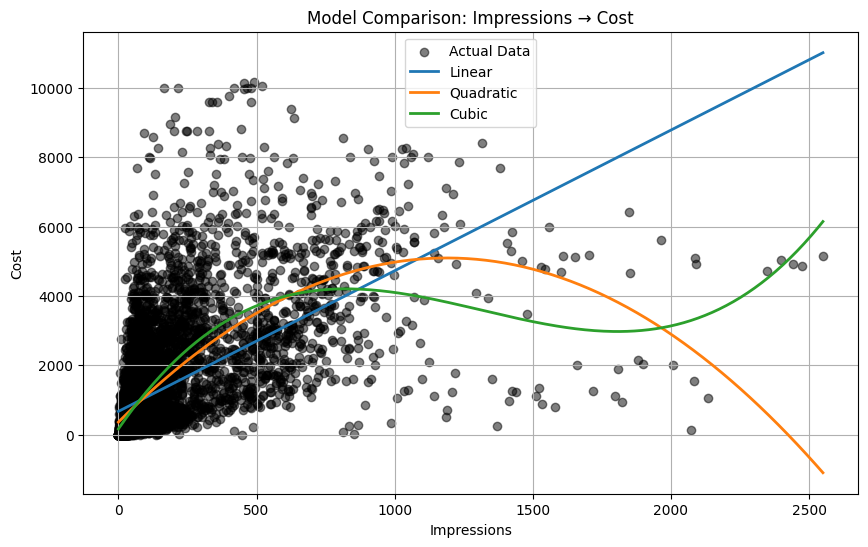

In [64]:
X_range = np.linspace(df_clean["Impressions"].min(), df_clean["Impressions"].max(), 300).reshape(-1,1)

plt.figure(figsize=(10,6))
plt.scatter(X, y, color="black", label="Actual Data", alpha=0.5)

plt.plot(X_range, linear_model.predict(X_range), label="Linear", linewidth=2)
plt.plot(X_range, quad_model.predict(X_range), label="Quadratic", linewidth=2)
plt.plot(X_range, cubic_model.predict(X_range), label="Cubic", linewidth=2)

plt.title("Model Comparison: Impressions → Cost")
plt.xlabel("Impressions")
plt.ylabel("Cost")
plt.legend()
plt.grid(True)
plt.show()


### Cell 10 — Model Evaluation & Best Model Selection

This cell calculates:

- **RMSE (Root Mean Squared Error):** Lower = better  
- **R² Score:** Higher = better  

A results table compares:
- Linear  
- Quadratic  
- Cubic  

Then it automatically selects the **best model** based on RMSE and R².

This provides objective performance measurement before recommending a model.


In [68]:
def evaluate(model):
    pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    return rmse, r2

total_cost_column = f"Total Cost for {user_duration} Days"

results = pd.DataFrame({
    "Model": ["Linear", "Quadratic", "Cubic"],
    "RMSE": [
        evaluate(linear_model)[0],
        evaluate(quad_model)[0],
        evaluate(cubic_model)[0]
    ],
    "R²": [
        evaluate(linear_model)[1],
        evaluate(quad_model)[1],
        evaluate(cubic_model)[1]
    ],
    "Cost prediction": [
        daily_linear,
        daily_quad,
        daily_cubic
    ],
    total_cost_column: [
        total_linear,
        total_quad,
        total_cubic
    ]
})

print(results)

best = results.sort_values(["RMSE", "R²"], ascending=[True, False]).iloc[0]["Model"]
print("\nRecommended Model:", best)


       Model         RMSE        R²  Cost prediction  Total Cost for 7 Days
0     Linear  1285.543130  0.343589      6752.534013           47267.738092
1  Quadratic  1181.615829  0.445432      4771.163535           33398.144746
2      Cubic  1153.299632  0.471692      3258.883707           22812.185952

Recommended Model: Cubic
